In [1]:
import yaml
import time
import random
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import time
from envs.photo_env import PhotoEnhancementEnv
from envs.photo_env import PhotoEnhancementEnvTest
from sac.sac_algorithm import SAC
import multiprocessing as mp
try:
    mp.set_start_method('spawn', force=True)
except RuntimeError:
    pass  


In [2]:
env = PhotoEnhancementEnv()
test_env = PhotoEnhancementEnvTest()
print(f'Sliders used {env.edit_sliders}')
print(f'Number of sliders used { env.num_parameters}')
print(f'Sliders used {test_env .edit_sliders}')
print(f'Number of sliders used {test_env .num_parameters}')

Sliders used ['contrast', 'exposure', 'shadows', 'highlights', 'whites']
Number of sliders used 5
Sliders used ['contrast', 'exposure', 'shadows', 'highlights', 'whites']
Number of sliders used 5


In [3]:
with open("configs/hyperparameters.yaml") as f:
    config_dict =yaml.load(f, Loader=yaml.FullLoader)
    
class Config(object):
    def __init__(self, dictionary):
        self.__dict__.update(dictionary)
sac_config = Config(config_dict)

SEED = sac_config.seed
DEVICE= 'CUDA'

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = sac_config.torch_deterministic
torch.autograd.set_detect_anomaly(True)

In [4]:
run_name = f"{sac_config.exp_name}__{sac_config.seed}__{int(time.time())}"
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(sac_config).items()])),
)
agent = SAC(env,sac_config,writer)

(32, 5) -5


/home/zakaria/miniconda3/envs/photoen/lib/python3.11/site-packages/torch/_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)


In [5]:
agent.start_time = time.time()
for i in range(sac_config.total_timesteps):
    episode_count = 0
    
    agent.reset_env()
    envs_mean_rewards =[]
    while True:     
        episode_count+=1
        agent.global_step+=1
        rewards,batch_dones = agent.train()
        envs_mean_rewards.append(rewards.mean().item())
        if(batch_dones==True).any():
            # print('one done')
            # print(agent.state.shape,agent.env.sub_env_running.shape)
            num_env_done = int(batch_dones.sum().item())
            agent.writer.add_scalar("charts/num_env_done", num_env_done , agent.global_step)
        if agent.global_step % 100 == 0:
            ens_mean_episodic_return = sum(envs_mean_rewards)
            agent.writer.add_scalar("charts/mean_episodic_return", ens_mean_episodic_return, agent.global_step)

        if (batch_dones==True).all()==True or episode_count==sac_config.max_episode_timesteps:
            episode_count=0           
            break 

    if agent.global_step%200==0:
        agent.backbone.eval()
        with torch.no_grad():
            n_images = 5
            obs = test_env.reset() 
            actions = agent.actor.get_action(obs.to(sac_config.device))
            _,rewards,dones = test_env.step(actions[0].cpu())
            agent.writer.add_scalar("charts/test_mean_episodic_return", rewards.mean().item(), agent.global_step)
            agent.writer.add_images("test_images",test_env.state['source_image'][:n_images],0)
            agent.writer.add_images("test_images",test_env.state['enhanced_image'][:n_images],1)
            agent.writer.add_images("test_images",test_env.state['target_image'][:n_images],2)
        agent.backbone.train()
            

SPS: 3
SPS: 2
SPS: 2
SPS: 2
SPS: 2
SPS: 2
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1
SPS: 1

KeyboardInterrupt: 

In [20]:
import cv2
import torch
import matplotlib.pyplot as plt
source_image = cv2.imread("sample_images/a0676-kme_609_original.jpg")
target_image = cv2.imread("sample_images/a0676-kme_609_C.jpg")
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB) /255.0
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB) /255.0

input = torch.Tensor(source_image).unsqueeze(0)

In [37]:
source_image.shape

(512, 340, 3)

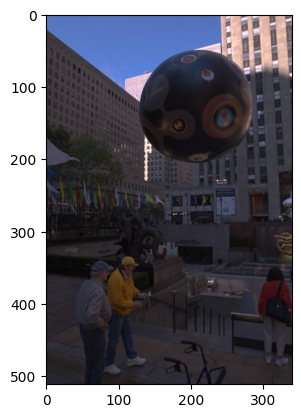

In [15]:
plt.imshow(source_image)

In [16]:
SLIDERS_TO_USE = ["contrast","exposure","shadows","highlights","whites"]
from envs.new_edit_photo import PhotoEditor
import matplotlib.pyplot as plt
photo_editor = PhotoEditor(SLIDERS_TO_USE)
photo_editor_UIE = PhotoEditor()

In [22]:
param_UIE = torch.tensor([0.125, 0.125, 0.375, 0.125, 0., 0.0625, 0.9375, 0.375, 0.0625, 0., 0.125, 0.125]).unsqueeze(0)

In [26]:
agent.backbone.eval()
agent.actor.eval()
with torch.no_grad():
    parameters = agent.actor.get_action(input.permute(0,3,1,2).cuda())
    enhanced_image = photo_editor(input.cpu(),parameters[0].cpu())
    enhanced_image_UIE = photo_editor_UIE(input.cpu(),param_UIE.cpu())
parameters

(tensor([[ 0.2897,  0.1497, -0.9791,  0.0050, -0.1506]], device='cuda:0'),
 tensor([[5.4691]], device='cuda:0'),
 tensor([[ 0.3541,  0.1380, -0.7736, -0.1186, -0.0346]], device='cuda:0'))

In [50]:
target_tensor = torch.Tensor(target_image).unsqueeze(0)
PSNR_UIE = test_env.compute_rewards(enhanced_image_UIE,target_tensor).item()+50
PSNR_OURS = test_env.compute_rewards(enhanced_image,target_tensor).item()+50

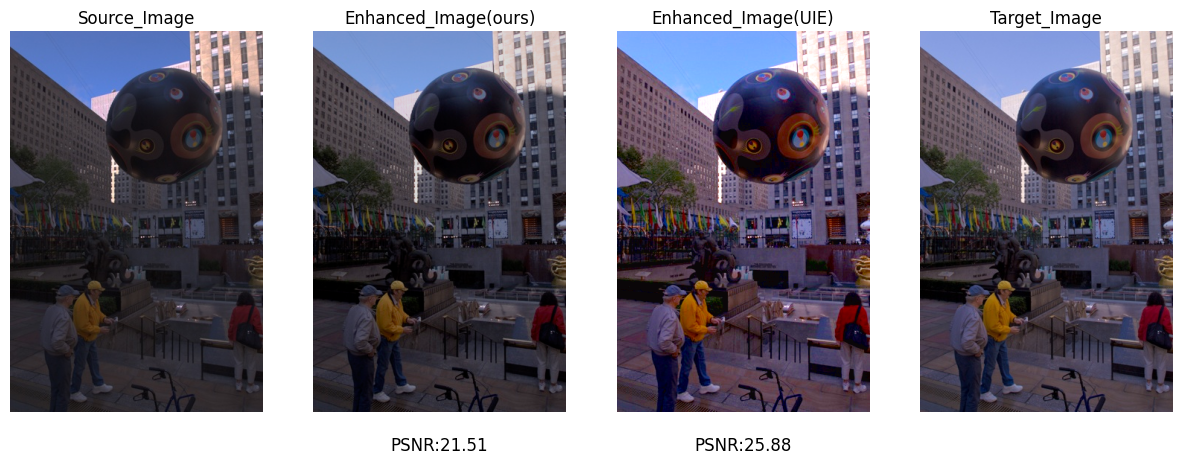

In [56]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
labels =["Source_Image","Enhanced_Image(ours)","Enhanced_Image(UIE)","Target_Image"]
imgs =[source_image,enhanced_image[0],enhanced_image_UIE[0],target_image]
PSNRS = [PSNR_OURS,PSNR_UIE]
for index,(img,label) in enumerate(zip(imgs,labels)):
    axes[index].imshow(img)
    axes[index].set_title(label)
    axes[index].axis('off')
    if index==1 or index==2:
        axes[index].text(0.5, -0.1, f'PSNR:{round(PSNRS[index-1],2)}', size=12, ha='center', transform=axes[index].transAxes)

In [58]:
torch.save(agent.actor.state_dict(), 'actor_model_5param.pth')